In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [67]:
img_raw = cv2.imread("data/20250215-180912/rec_0000.png", cv2.IMREAD_ANYDEPTH).astype(np.float32) / 65535

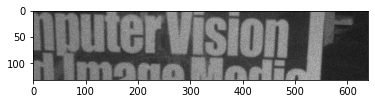

In [68]:
plt.imshow(img_raw, cmap='gray')

In [69]:
img =  [
    img_raw[0::2, 0::2],
    img_raw[0::2, 1::2],
    img_raw[1::2, 0::2],
    img_raw[1::2, 1::2]
]

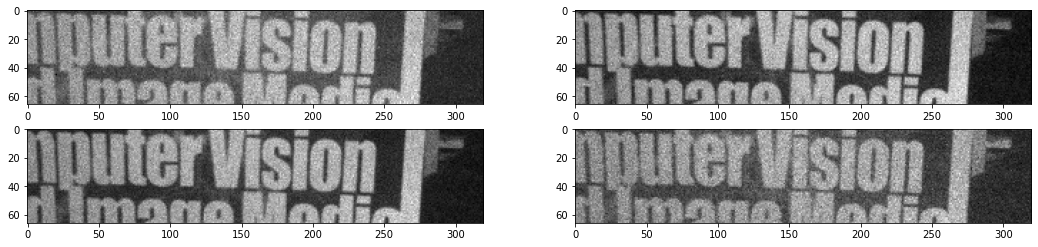

In [70]:
plt.figure(figsize=(18, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(img[i], cmap='gray')


In [71]:
sigma = 1.0
img0 = cv2.GaussianBlur(img[0], (0, 0), sigma)

In [72]:
def read_raw_image(filename, sigma = 1.0):
    img_raw = cv2.imread(filename, cv2.IMREAD_ANYDEPTH).astype(np.float32) / 65535
    img =  np.array([
        img_raw[0::2, 0::2],
        img_raw[0::2, 1::2],
        img_raw[1::2, 0::2],
        img_raw[1::2, 1::2]
    ])
    for i in range(4):
        img[i] = cv2.GaussianBlur(img[i], (0, 0), sigma)
    return img

def imshow_raw_image(img):
    plt.figure(figsize=(18, 4))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(img[i], cmap='gray')

def calc_grad(img):
    '''勾配計算'''

    # Sobleフィルタ
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    
    # Sobelフィルタの係数総和の8で割って傾きを正規化
    grad_x /= 8
    grad_y /= 8
    return grad_x, grad_y

def calc_grad_raw(raw):
    grad_x = []
    grad_y = []
    for i in range(4):
        gx, gy = calc_grad(raw[i])
        grad_x.append(gx)
        grad_y.append(gy)
    grad_x = np.array(grad_x)
    grad_y = np.array(grad_y)
    return np.mean(grad_x, axis=0), np.mean(grad_y, axis=0)

def calc_diff_raw(raw0, raw1):
    return np.mean(raw1 - raw0, axis=0)

def calc_mean_raw(raw0, raw1):
    return np.mean(raw1 + raw0, axis=0)


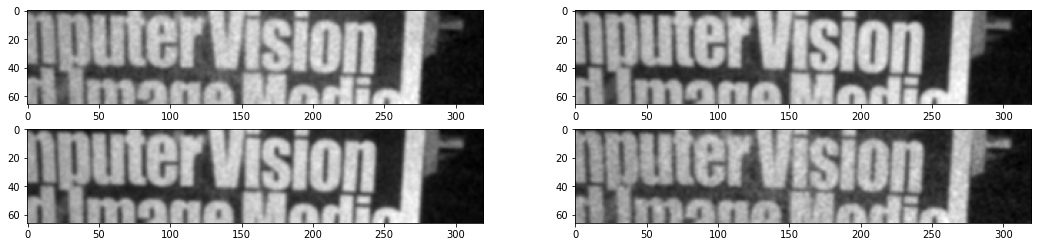

In [73]:
img = read_raw_image("data/20250215-180912/rec_0000.png", sigma = 1.0)
imshow_raw_image(img)

In [74]:
img0 = read_raw_image("data/20250215-180912/rec_0000.png", sigma = 1.0)[:,:,96:224]
img1 = read_raw_image("data/20250215-180912/rec_0001.png", sigma = 1.0)[:,:,96:224]


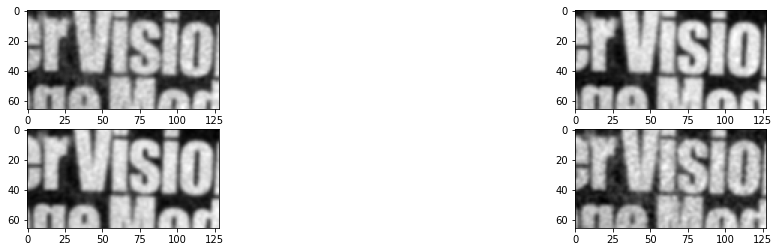

In [75]:
imshow_raw_image(img0)

In [76]:
def lucas_kanade(img0, img1):
    # 移動量推定
    diff = calc_diff_raw(img0, img1)
    gx0, gy0 = calc_grad_raw(img0)
    gx1, gy1 = calc_grad_raw(img1)
    gx = (gx0 + gx1) / 2
    gy = (gy0 + gy1) / 2

    gx2 = np.sum(gx**2)
    gxy = np.sum(gx*gy)
    gy2 = np.sum(gy**2)
    e0  = np.sum(diff*gx)
    e1  = np.sum(diff*gy)

    G = np.array([[gx2, gxy], [gxy, gy2]])
    E = np.array([e0, e1])
    D = np.linalg.solve(G, E)

    dx = -D[0]
    dy = -D[1]
#   print("dx, dy = ", dx, dy)

    # 回転量推定
    w = img0.shape[2]
    h = img0.shape[1]
    cx = (w-1) / 2
    cy = (h-1) / 2
    x, y = np.meshgrid(np.arange(w)-cx, np.arange(h)-cy)
    a = np.sum((-gx*y + gy*x)**2)
    b = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
    c = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
    d = np.sum((gx*x + gy*y)**2)
    e0 = np.sum(diff * (-gx*y + gy*x))
    e1 = np.sum(diff * ( gx*x + gy*y))

    G = np.array([[a, b], [c, d]])
    E = np.array([e0, e1])
    D = np.linalg.solve(G, E)

    dt = D[0]
    ds = -D[1]

    return dx, dy, dt




In [77]:
path = "data/20250215-180912"#/rec_0000.png"
path = "data/20250215-180427"

hist_x = []
hist_y = []
hist_dx = []
hist_dy = []

x = 0.0
y = 0.0
for i in range(500):
    file0 = f"{path}/rec_{i:04}.png"
    file1 = f"{path}/rec_{i+1:04}.png"
    img0 = read_raw_image(file0, sigma = 1.0)[:,:,96:224]
    img1 = read_raw_image(file1, sigma = 1.0)[:,:,96:224]
    dx, dy, dt = lucas_kanade(img0, img1)
#   print("dx, dy = ", dx, dy)
    x += dx*2
    y += dy*2
    img = cv2.imread(file0)
    cv2.circle(img, (320+int(x), 66+int(y)), 10, (0, 0, 255), -1)
    cv2.imshow("img", img)
    cv2.waitKey(1)
    hist_x.append(x)
    hist_y.append(y)
    hist_dx.append(dx*2)
    hist_dy.append(dy*2)

cv2.destroyAllWindows()

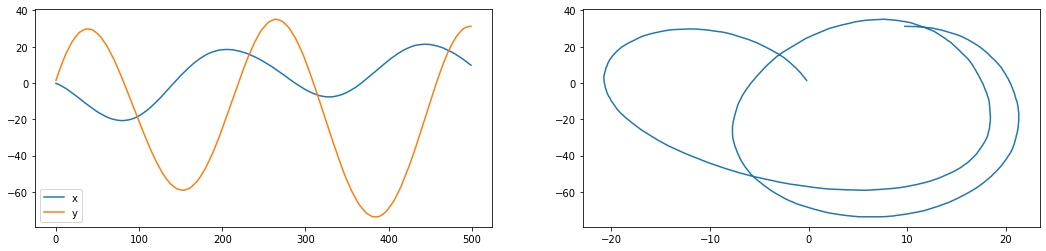

In [78]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_x, label="x")
plt.plot(hist_y, label="y")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_x, hist_y)
plt.show()

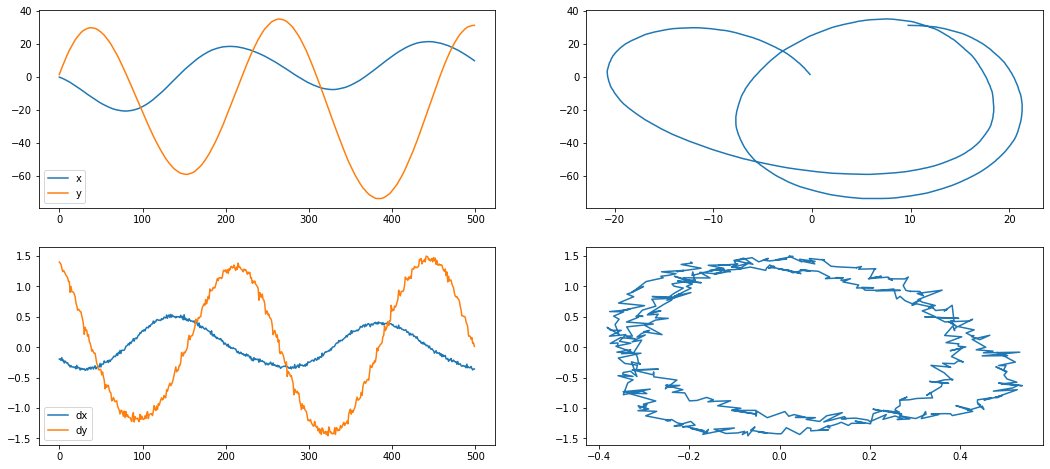

In [79]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(hist_x, label="x")
plt.plot(hist_y, label="y")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(hist_x, hist_y)
plt.subplot(2, 2, 3)
plt.plot(hist_dx, label="dx")
plt.plot(hist_dy, label="dy")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(hist_dx, hist_dy)

In [80]:
path = "data/20250215-180912"
#path = "data/20250215-180427"

# 動画保存
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = None

hist_x = []
hist_y = []
hist_t = []

x = 0.0
y = 0.0
t = 0.0
for i in range(700):
    file0 = f"{path}/rec_{i:04}.png"
    file1 = f"{path}/rec_{i+1:04}.png"
    img0 = read_raw_image(file0, sigma = 1.0)[:,:,96:224]
    img1 = read_raw_image(file1, sigma = 1.0)[:,:,96:224]
    dx, dy, dt = lucas_kanade(img0, img1)
#   print("dx, dy = ", dx, dy)
    x += dx*2
    y += dy*2
    t += dt
    img = cv2.imread(file0) # [:,192:448,:]
    cx = img.shape[1] // 2
    cy = img.shape[0] // 2
    cv2.circle(img, (cx+int(x), cy+int(y)), 10, (0, 0, 255), 1)
    cv2.circle(img, (cx+int(x), cy+int(y)), 3, (0, 0, 255), -1)

    s = -np.sin(t) * 100
    c = np.cos(t) + 100
    cv2.line(img, (int(cx-c), int(cy-s)), (int(cx+c), int(cy+s)), (0, 0, 255), 1)

    cv2.imshow("img", img)
    cv2.waitKey(1)

    if video is None:
        video = cv2.VideoWriter('output2.mp4', fourcc, 30.0, (img.shape[1], img.shape[0]))
    video.write(img)

    hist_x.append(x)
    hist_y.append(y)
    hist_t.append(t)

video.release()
cv2.destroyAllWindows()

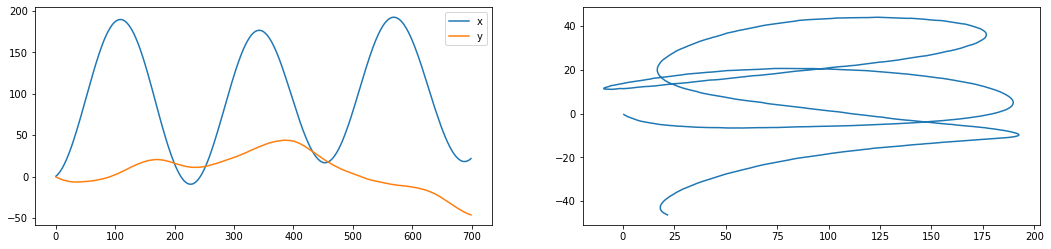

In [81]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_x, label="x")
plt.plot(hist_y, label="y")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_x, hist_y)
plt.show()

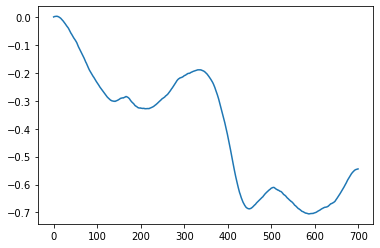

In [82]:
plt.plot(hist_t, label="t")